In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

# Clean Data:

In [2]:
diamonds = pd.read_csv("../input_diamonds/diamonds_train.csv")

In [3]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40345 entries, 0 to 40344
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  40345 non-null  int64  
 1   carat       40345 non-null  float64
 2   cut         40345 non-null  object 
 3   color       40345 non-null  object 
 4   clarity     40345 non-null  object 
 5   depth       40345 non-null  float64
 6   table       40345 non-null  float64
 7   x           40345 non-null  float64
 8   y           40345 non-null  float64
 9   z           40345 non-null  float64
 10  price       40345 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 3.4+ MB


**Distribution of the data of each 10 properties**:

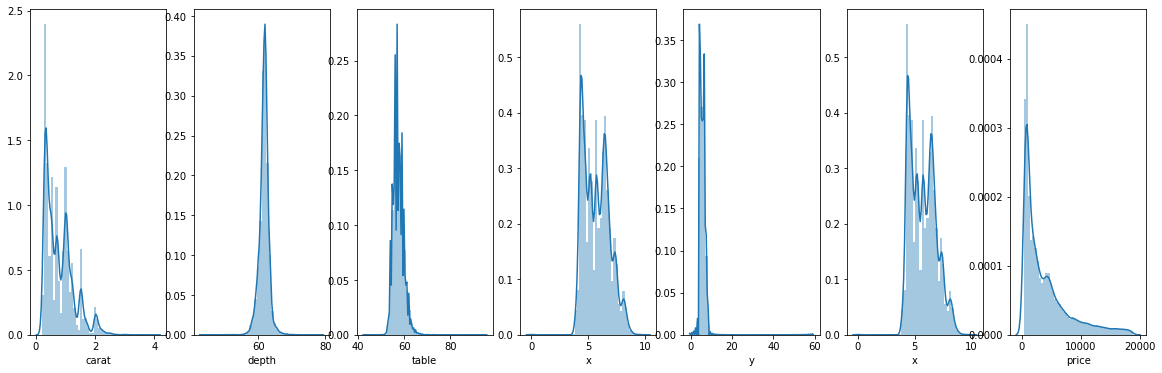

In [4]:
fig,axes = plt.subplots(1,7, figsize = (20,6))
sns.distplot(diamonds['carat'],ax=axes[0])
sns.distplot(diamonds['depth'],ax=axes[1])
sns.distplot(diamonds['table'],ax=axes[2])
sns.distplot(diamonds['x'],ax=axes[3])
sns.distplot(diamonds['y'],ax=axes[4])
sns.distplot(diamonds['x'],ax=axes[5])
sns.distplot(diamonds['price'],ax=axes[6])
plt.show()

*The price distribution is skewed right*

**We log transformed the price data in order to reduce the right skew in distribution.**

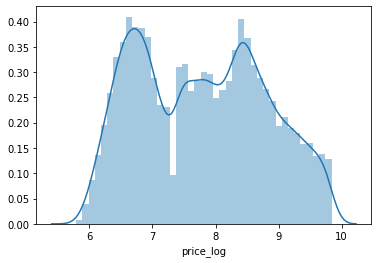

In [5]:
price_log = np.log(diamonds.price)
diamonds["price_log"]= price_log
sns.distplot(diamonds['price_log'])

**Heatmap of the correlations between each of the features:**

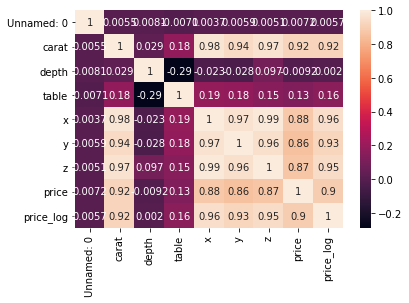

In [6]:
corr = diamonds.corr()
ax = sns.heatmap(corr,annot=True)

*x, y, z,and carat are highly correlated. This means that the diamonds mostly share the same proportions in terms of dimensions and mass.*

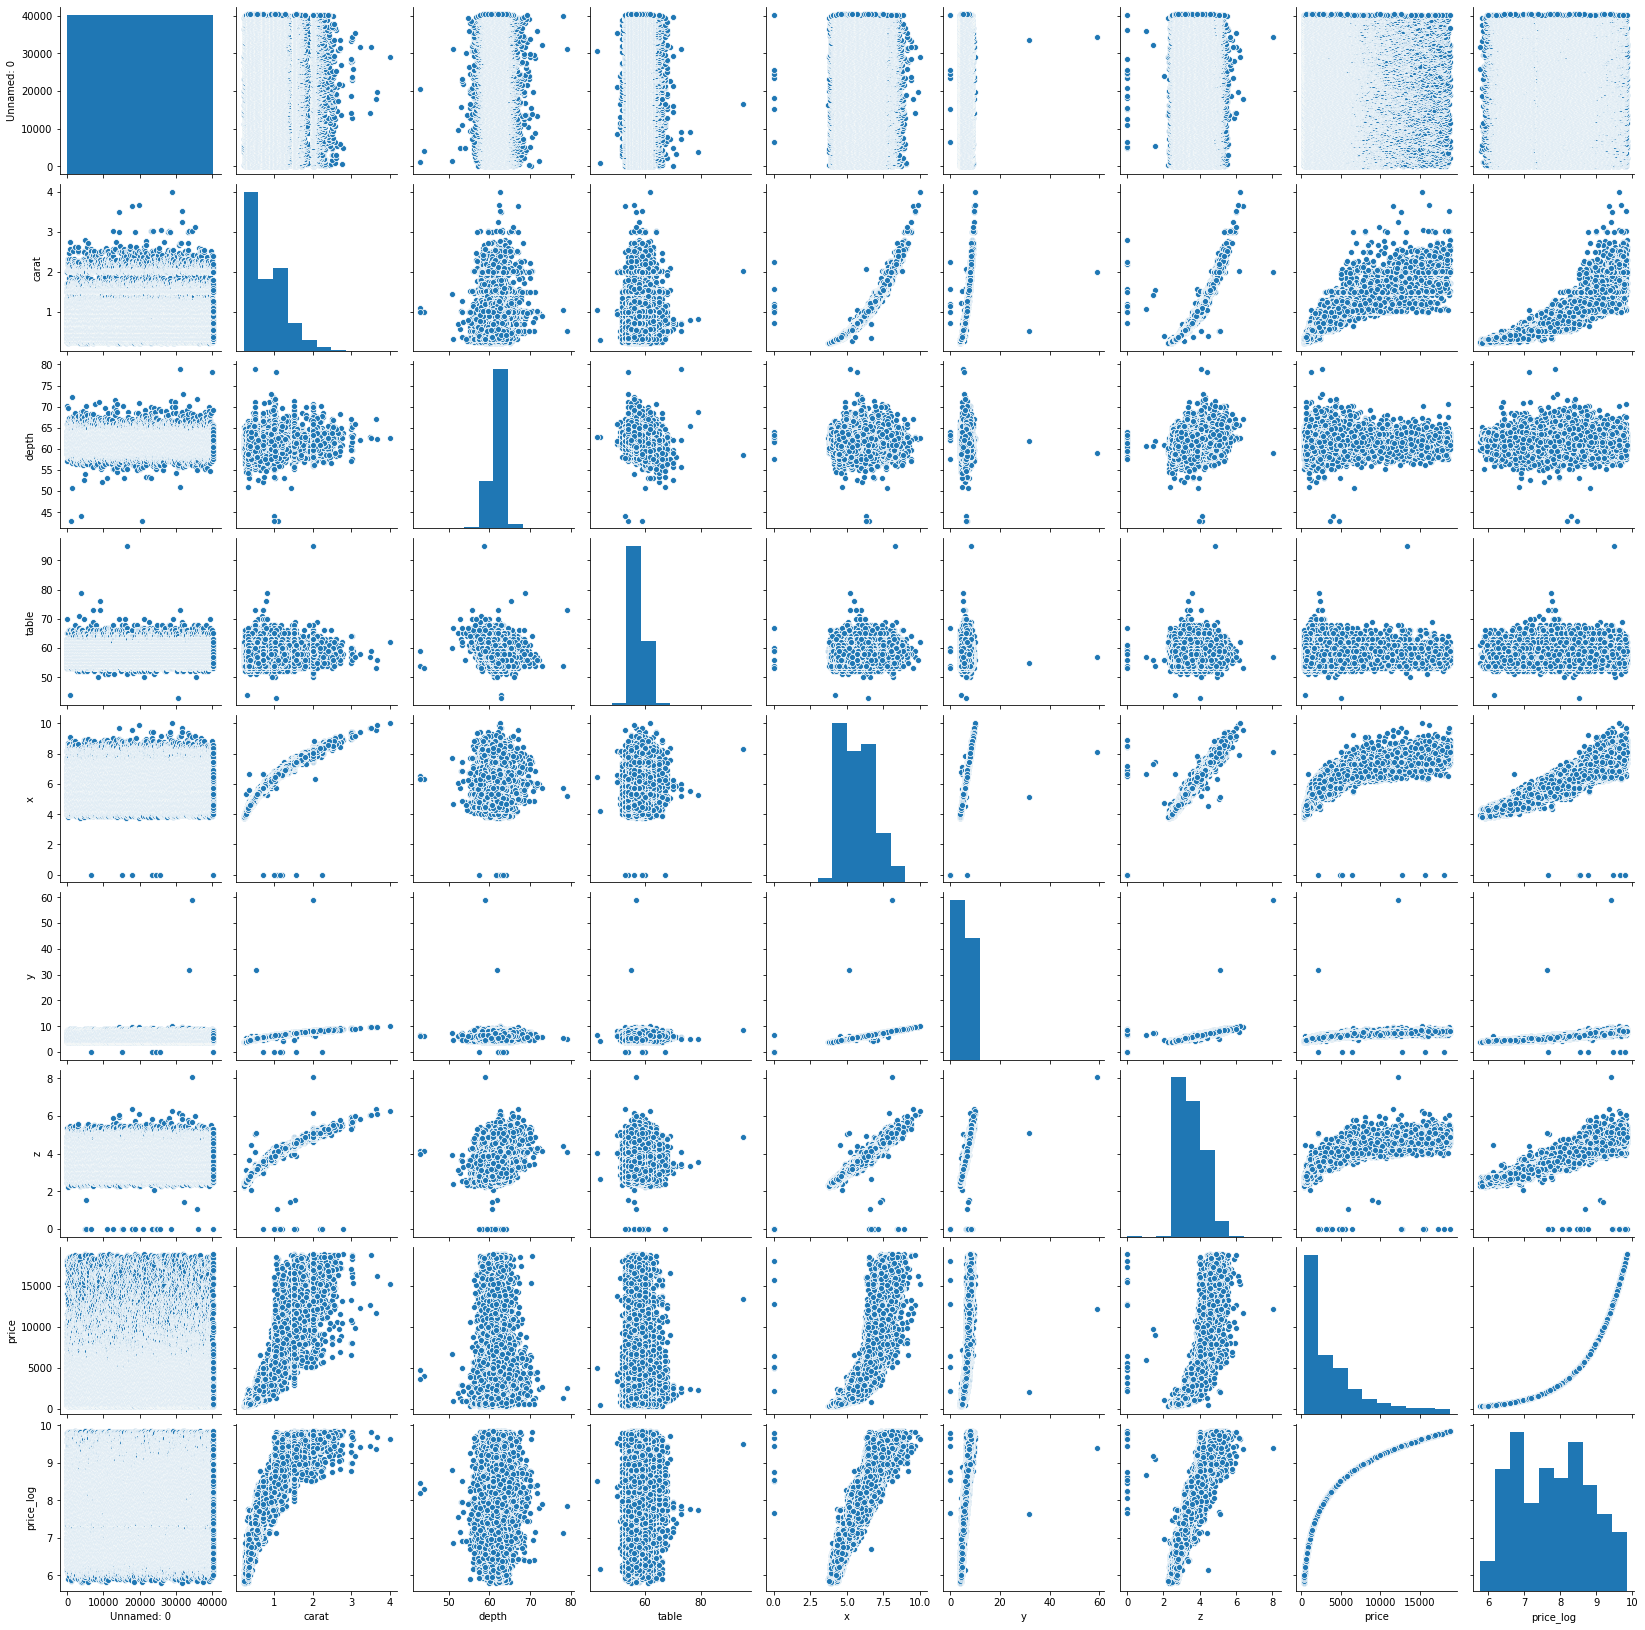

In [7]:
sns.pairplot(diamonds)

*There is some positive relationship between cut, clarity, and color with price, and we can base a predictor based off of these features.*

**The depth, table, length, x, y, and z axis lengths were given as numerical data. Thus, we normalized the data by subtracting the mean from each data point and dividing by the standard deviation:**

In [8]:
columns = ['carat','depth', 'table', 'x', 'y', 'z']
for col in columns:
    diamonds[col] = (diamonds[col] - np.mean(diamonds[col])) / np.std(diamonds[col]) 
diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price,price_log
0,0,0.880093,Ideal,H,VS2,0.877395,-0.205924,0.897395,0.844339,1.001745,6134,8.721602
1,1,-1.095267,Very Good,D,VVS2,1.579543,-0.653290,-1.417842,-1.358400,-1.261634,532,6.276643
2,2,-0.797901,Premium,F,VS1,-0.386471,0.241442,-0.774224,-0.792479,-0.829141,1103,7.005789
3,3,-1.137748,Ideal,H,IF,-0.456686,-0.205924,-1.399964,-1.401932,-1.449047,600,6.396930
4,4,0.646448,Good,G,SI1,1.158254,-0.205924,0.709673,0.713742,0.871998,4997,8.516593


**The carat, clarity, color,and cut were given as categorical data so we converted it to a feature vector by mapping them to a sequential integer range with zero mean:**

In [9]:
#diamonds=pd.get_dummies(diamonds)
#diamonds.head()

In [10]:
diamonds["cut"].replace(["Premium", "Ideal", "Very Good","Good","Fair"],[2,1,0,-1,-2],inplace=True)
diamonds["color"].replace(["G", "E", "F","H","D","I","J"],[3,2,1,0,-1,-2,-3],inplace=True)
diamonds["clarity"].replace(["SI1", "VS2", "SI2","VS1","VVS2","VVS1","IF","I1"],[4,3,2,1,0,-1,-2,-3],inplace=True)

*Changing {cut, color,clarity} from one-hot representations to numerical ones improved performance*

In [11]:
diamonds["volume"]=diamonds['x']*diamonds['y']*diamonds['z']

In [12]:
diamonds.drop(['x','y','z','Unnamed: 0'],axis=1,inplace=True)

# Train models:

In [13]:
X=diamonds.drop(columns=["price","price_log"])
y=diamonds["price"]
display(X.head(),y.head())

,carat,cut,color,clarity,depth,table,volume
0,0.880093,1,0,3,0.877395,-0.205924,0.759028
1,-1.095267,0,-1,0,1.579543,-0.653290,-2.429902
2,-0.797901,2,1,1,-0.386471,0.241442,-0.508725
3,-1.137748,1,0,-2,-0.456686,-0.205924,-2.843979
4,0.646448,-1,3,4,1.158254,-0.205924,0.441687


0    6134
1     532
2    1103
3     600
4    4997
Name: price, dtype: int64

In [14]:
#pca = PCA(n_components=6)
#XReduced = pd.DataFrame(pca.fit_transform(X))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32276, 7) (8069, 7) (32276,) (8069,)


# Random Forest:

In [16]:
model= RandomForestRegressor(n_estimators=1500).fit(X_train, y_train)
y_pred=model.predict(X_test)
print(np.mean(cross_val_score(model, X_train, y_train, scoring='r2', cv=3, n_jobs=2)))
print("r2_score", r2_score(y_test,y_pred))
print("RSME", (mean_squared_error(y_test,y_pred)**0.5))

0.9772649073129728
r2_score 0.9815310746408953
RSME 543.2868672784241


# Gradient Booster:

In [17]:
#model2= GradientBoostingRegressor(n_estimators=1000).fit(X_train, y_train)
#y_pred=model2.predict(X_test)
#print(np.mean(cross_val_score(model2, X_train, y_train, scoring='r2', cv=3, n_jobs=2)))
#print("r2_score", r2_score(y_test,y_pred))
#print("RSME", (mean_squared_error(y_test,y_pred)**0.5)) 

# Test:

In [26]:
diamonds_test = pd.read_csv("../input_diamonds/diamonds_test.csv")
diamonds_test.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.30,Ideal,H,SI2,60.0,56.0,4.41,4.43,2.65
1,1,0.34,Ideal,D,IF,62.1,57.0,4.52,4.46,2.79
2,2,1.57,Very Good,I,VS2,60.3,58.0,7.58,7.55,4.56
3,3,0.31,Ideal,H,VS2,61.8,57.0,4.32,4.36,2.68
4,4,1.51,Good,I,VVS1,64.0,60.0,7.26,7.21,4.63


In [27]:
columns = ['carat','depth', 'table', 'x', 'y', 'z']
for col in columns:
    diamonds_test[col] = (diamonds_test[col] - np.mean(diamonds_test[col])) / np.std(diamonds_test[col]) 
diamonds_test.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z
0,0,-1.048154,Ideal,H,SI2,-1.203383,-0.651290,-1.186402,-1.178130,-1.218748
1,1,-0.964994,Ideal,D,IF,0.248074,-0.202597,-1.088759,-1.151313,-1.029048
2,2,1.592168,Very Good,I,VS2,-0.996032,0.246095,1.627504,1.610849,1.369302
3,3,-1.027364,Ideal,H,VS2,0.040723,-0.202597,-1.266292,-1.240704,-1.178098
4,4,1.467429,Good,I,VVS1,1.561297,1.143481,1.343450,1.306922,1.464152


In [28]:
diamonds_test["cut"].replace(["Premium", "Ideal", "Very Good","Good","Fair"],[2,1,0,-1,-2],inplace=True)
diamonds_test["color"].replace(["G", "E", "F","H","D","I","J"],[3,2,1,0,-1,-2,-3],inplace=True)
diamonds_test["clarity"].replace(["SI1", "VS2", "SI2","VS1","VVS2","VVS1","IF","I1"],[4,3,2,1,0,-1,-2,-3],inplace=True)

In [29]:
diamonds_test["volume"]=diamonds_test['x']*diamonds_test['y']*diamonds_test['z']

In [30]:
diamonds_test.drop(['x','y','z','Unnamed: 0'],axis=1,inplace=True)

In [31]:
price_pred=model.predict(diamonds_test) 

In [24]:
df_price=pd.DataFrame({'price':price_pred})
df_price.index.rename('id', inplace=True)
df_price

,price
id,
0,450.824667
1,1748.121333
2,9099.078000
3,516.338000
4,9195.806667
...,...
13444,4402.830667
13445,441.401333
13446,14840.870000


In [32]:
df_price.to_csv("./output/test12.csv")